Initializing portfolio for ['NVDA', 'MTDR', 'RRC'] from 2019-01-01 to 2025-03-10
Investment amount: $100000

Fetching daily returns data...

Processing NVDA...
Connection successful for NVDA

Processing MTDR...
Connection successful for MTDR

Processing RRC...
Connection successful for RRC

Processing SPY...
Connection successful for SPY

Calculating monthly returns...
Created monthly returns dataset with 73 months of data

Fetching risk-free rate...
Annual risk-free rate: 0.042485
Based on 3-month Treasury yield as of: 2025-04-10

Fetching latest prices...

Getting latest price for NVDA...
Connection successful for NVDA
Latest price for NVDA: 106.970757667387

Getting latest price for MTDR...
Connection successful for MTDR
Latest price for MTDR: 45.02

Getting latest price for RRC...
Connection successful for RRC
Latest price for RRC: 36.3745691226243

Calculating covariance matrix...

Calculating betas and expected returns using CAPM...
Annual expected return of SPY: 14.62%

Beta val

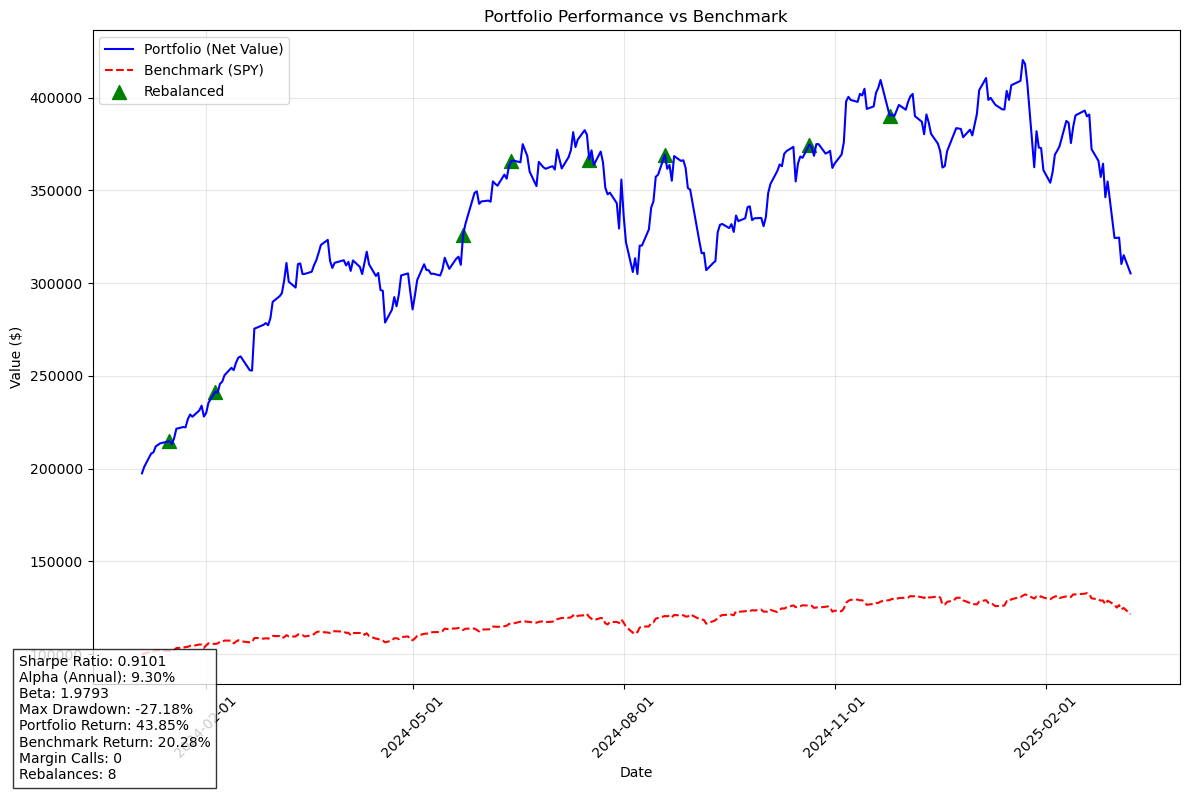

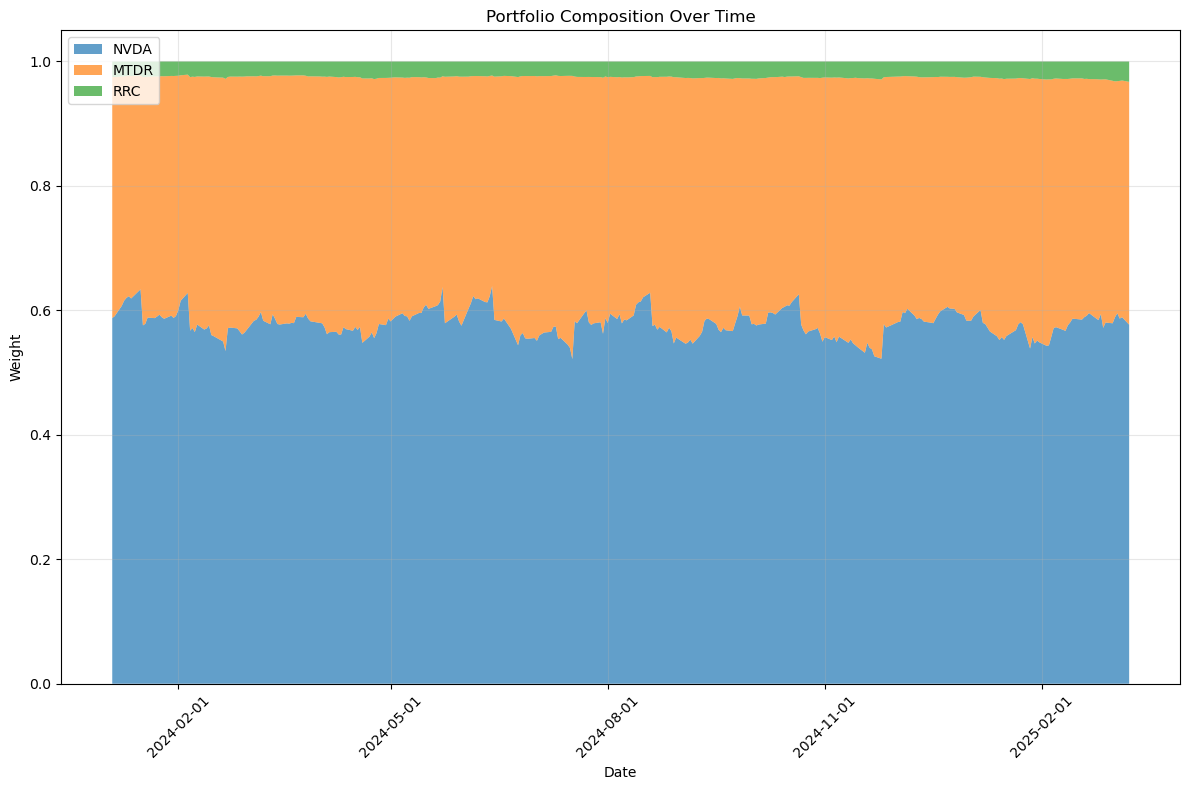


Backtest Summary:
Time Period: 2024-01-04 to 2025-03-10
Number of Trading Days: 295
Initial Investment: $100000.00
Final Portfolio Value: $305277.81
Total Return: 205.28%
Number of Margin Calls: 0
Total Margin Call Amount: $0.00
Number of Rebalances: 8
Total Trading Fees: $2993.67

Tangent Portfolio Weights (from estimation period):
NVDA: 0.5750
MTDR: 0.3998
RRC: 0.0252

Backtest completed successfully!


In [93]:
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

class PortfolioManagementSystem:
    """
    A comprehensive portfolio management system that handles:
    - Initial allocation
    - Margin call detection
    - Post-margin call adjustments
    - Portfolio rebalancing
    - Performance tracking
    - Backtesting
    """
    
    def __init__(self, api_key):
        """
        Initialize the portfolio management system
        
        Parameters:
        api_key (str): AlphaVantage API key
        """
        self.api_key = api_key
        self.portfolio = None
        self.backtest_results = None
    
    def get_prices(self, start_date, end_date, ticker):
        """
        Fetch daily adjusted prices for a ticker within the specified date range
        
        Parameters:
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        ticker (str): Stock ticker symbol
        
        Returns:
        list: List of [ticker, date, adjusted_close] lists
        """
        info = []
        ticker_param = '&symbol=' + str(ticker)
        endpoint = 'function=TIME_SERIES_DAILY_ADJUSTED'
        size = '&outputsize=full'
        base_url = 'https://www.alphavantage.co/query?'
        url = base_url + endpoint + ticker_param + size + '&apikey=' + self.api_key
        
        try:
            r = requests.get(url)
            if r.status_code == 200:
                print(f'Connection successful for {ticker}')
                data = r.json()
                
                # Check if we have data and no error messages
                if 'Time Series (Daily)' in data:
                    daily_data = data['Time Series (Daily)']
                    
                    for date, values in sorted(daily_data.items()):
                        if start_date <= date <= end_date:
                            info.append([ticker, date, values['5. adjusted close']])
                else:
                    print(f"Error or no data for {ticker}: {data.get('Error Message', 'Unknown error')}")
            else:
                print(f'Failed to fetch data for {ticker}: Status code {r.status_code}')
        except Exception as e:
            print(f'Exception when fetching data for {ticker}: {e}')
        
        return info
    
    def calculate_log_returns(self, df):
        """
        Calculate log returns from price data
        
        Parameters:
        df (pandas.DataFrame): DataFrame with Date and Value columns
        
        Returns:
        pandas.DataFrame: DataFrame with Date and Log_Returns columns
        """
        # Sort by date to ensure correct calculations
        df = df.sort_values("Date")
        
        # Calculate log returns
        df["Log_Returns"] = np.log(df["Value"] / df["Value"].shift(1))
        
        # Extract just Date and Log_Returns and drop NA values
        returns = df[["Date", "Log_Returns"]].dropna()
        
        return returns
    
    def get_stock_returns(self, ticker_list, start_date, end_date, delay=0):
        """
        Fetch prices and calculate log returns for multiple stocks
        
        Parameters:
        ticker_list (list): List of ticker symbols
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        delay (int): Delay between API calls in seconds
        
        Returns:
        pandas.DataFrame: DataFrame with Date and log returns for each ticker
        """
        # Initialize an empty DataFrame for the combined results
        combined_returns = pd.DataFrame()
        
        # Process each ticker
        for ticker in ticker_list:
            print(f"\nProcessing {ticker}...")
            
            # Add a delay to avoid API rate limits
            time.sleep(delay)
            
            # Get price data
            price_data = self.get_prices(start_date, end_date, ticker)
            
            if not price_data:
                print(f"No data retrieved for {ticker}")
                continue
            
            # Convert to DataFrame
            price_df = pd.DataFrame(price_data, columns=["Ticker", "Date", "Value"])
            
            # Convert Value to numeric
            price_df["Value"] = pd.to_numeric(price_df["Value"], errors="coerce")
            
            # Calculate log returns
            returns_df = self.calculate_log_returns(price_df)
            
            # Rename the Log_Returns column to the ticker name
            returns_df = returns_df.rename(columns={"Log_Returns": ticker})
            
            # Add to combined results
            if combined_returns.empty:
                combined_returns = returns_df
            else:
                combined_returns = pd.merge(combined_returns, returns_df, on="Date", how="outer")
        
        # Sort by date
        if not combined_returns.empty and "Date" in combined_returns.columns:
            combined_returns = combined_returns.sort_values("Date")
        
        return combined_returns
    
    def get_latest_prices(self, ticker_list, start_date, end_date, delay=0):
        """
        Fetch the latest adjusted closing price for each ticker and return as a vertical array
        
        Parameters:
        ticker_list (list): List of ticker symbols
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        delay (int): Delay between API calls in seconds
        
        Returns:
        numpy.ndarray: Vertical array of latest prices
        dict: Dictionary mapping tickers to latest prices
        """
        latest_prices = []
        latest_prices_dict = {}
        
        for ticker in ticker_list:
            print(f"\nGetting latest price for {ticker}...")
            
            # Add a delay to avoid API rate limits
            time.sleep(delay)
            
            # Get price data
            price_data = self.get_prices(start_date, end_date, ticker)
            
            if not price_data:
                print(f"No data retrieved for {ticker}, using placeholder value of 0")
                latest_prices.append([0])
                latest_prices_dict[ticker] = 0
                continue
            
            # Convert to DataFrame
            price_df = pd.DataFrame(price_data, columns=["Ticker", "Date", "Value"])
            
            # Convert Value to numeric
            price_df["Value"] = pd.to_numeric(price_df["Value"], errors="coerce")
            
            # Sort by date (descending) to get the most recent price first
            price_df = price_df.sort_values("Date", ascending=False)
            
            # Get the most recent price
            if not price_df.empty:
                latest_price = price_df["Value"].iloc[0]
                latest_prices.append([latest_price])
                latest_prices_dict[ticker] = latest_price
                print(f"Latest price for {ticker}: {latest_price}")
            else:
                print(f"No valid price data for {ticker}, using placeholder value of 0")
                latest_prices.append([0])
                latest_prices_dict[ticker] = 0
        
        # Convert list to numpy array
        p0_m = np.array(latest_prices)
        
        # Set display options to avoid scientific notation
        np.set_printoptions(suppress=True, precision=6)
        
        return p0_m, latest_prices_dict
    
    def get_risk_free_rate(self):
        """
        Get the current 3-month Treasury bill rate and convert to continuously compounded
        
        Returns:
        float: Continuously compounded annual risk-free rate
        str: Date of the Treasury yield data
        """
        url = f'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=3month&apikey={self.api_key}'
        try:
            r = requests.get(url)
            r1 = r.json()
            
            # Check if we have valid data
            if 'data' in r1 and len(r1['data']) > 0:
                # Get current 3-month yield
                rftbill = float(r1['data'][0]['value']) / 100
                datetbill = r1['data'][0]['date']
                rfcc = np.log(1 + rftbill)  # annual continuously compounded rate
                print(f"Annual risk-free rate: {rfcc:.6f}")
                print(f"Based on 3-month Treasury yield as of: {datetbill}")
                return rfcc, datetbill
            else:
                print(f"Error retrieving Treasury yield data: {r1.get('Error Message', 'Unknown error')}")
                print("Using default risk-free rate of 0.02 (2%)")
                return 0.02, datetime.now().strftime('%Y-%m-%d')
        except Exception as e:
            print(f"Exception when fetching Treasury yield data: {e}")
            print("Using default risk-free rate of 0.02 (2%)")
            return 0.02, datetime.now().strftime('%Y-%m-%d')
    
    def initial(self, ticker_list, start_date, end_date, margin_pct=None, investment_amount=10000, benchmark_ticker='SPY', delay=0):
        """
        Initial portfolio allocation based on tangent portfolio with margins
        
        Parameters:
        ticker_list (list): List of ticker symbols
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        margin_pct (list or float): Initial margin percentages for each ticker (0.5 = 50%)
                                  If None, defaults to 0.5 for all tickers
        investment_amount (float): Initial investment amount in dollars
        benchmark_ticker (str): Ticker symbol for benchmark (default: 'SPY')
        delay (int): Delay between API calls in seconds
        
        Returns:
        dict: Dictionary with initial portfolio allocation details
        """
        print(f"Initializing portfolio for {ticker_list} from {start_date} to {end_date}")
        print(f"Investment amount: ${investment_amount}")
        
        # Set default margin percentages if not provided
        if margin_pct is None:
            margin_pct = [0.5] * len(ticker_list)
        elif isinstance(margin_pct, (int, float)):
            margin_pct = [float(margin_pct)] * len(ticker_list)
        
        margins = np.array(margin_pct).reshape(-1, 1)
        
        # Get benchmark ticker if not in the list
        full_ticker_list = ticker_list.copy()
        if benchmark_ticker not in full_ticker_list:
            full_ticker_list.append(benchmark_ticker)
    
        # Get daily returns for all tickers including benchmark
        print("\nFetching daily returns data...")
        returns_df = self.get_stock_returns(full_ticker_list, start_date, end_date, delay)
        
        if returns_df.empty:
            print("Error: No valid returns data could be retrieved. Please check your inputs.")
            return None
        
        # Create monthly returns (resampled to month end)
        print("\nCalculating monthly returns...")
        returns_df_copy = returns_df.copy()
        returns_df_copy = returns_df_copy.set_index('Date')
        returns_df_copy.index = pd.to_datetime(returns_df_copy.index)
        
        # Resample to month end and remove first and last month
        monthly_returns = returns_df_copy.resample('ME').sum()
        if len(monthly_returns) > 2:  # Ensure we have enough data
            monthly_returns = monthly_returns[1:-1]
            print(f"Created monthly returns dataset with {len(monthly_returns)} months of data")
        else:
            print("Warning: Not enough data for proper monthly returns calculation")
        
        # Get risk-free rate
        print("\nFetching risk-free rate...")
        rfcc, rf_date = self.get_risk_free_rate()
        
        # Get latest prices
        print("\nFetching latest prices...")
        p0_m, latest_prices_dict = self.get_latest_prices(ticker_list, start_date, end_date, delay)
        
        # Calculate covariance matrix of stock returns
        print("\nCalculating covariance matrix...")
        returns_only = returns_df_copy[ticker_list]
        sigma = returns_only.cov()
        
        # Check if sigma is positive semi-definite
        eigenvalues, _ = np.linalg.eig(sigma)
        if any(eigenvalues <= 0):
            print("Warning: Covariance matrix is not positive semi-definite. Results may be unreliable.")
        
        # Calculate betas and expected returns using CAPM
        print("\nCalculating betas and expected returns using CAPM...")
        beta_array = np.zeros((len(ticker_list), 1))
        expected_returns_array = np.zeros((len(ticker_list), 1))
        
        # Calculate benchmark annual return
        benchmark_returns = returns_df_copy[benchmark_ticker].dropna().values
        trading_days_per_year = 252
        annual_benchmark_return = np.mean(benchmark_returns) * trading_days_per_year
        print(f"Annual expected return of {benchmark_ticker}: {annual_benchmark_return*100:.2f}%")
        
        # Calculate betas for each stock
        for i, ticker in enumerate(ticker_list):
            if ticker == benchmark_ticker:
                beta_array[i] = 1
            else:
                # Use monthly returns for beta calculation as specified
                common_data = monthly_returns.dropna(subset=[ticker, benchmark_ticker])
                
                if len(common_data) > 0:
                    stock_returns = common_data[ticker].values
                    benchmark_subset = common_data[benchmark_ticker].values
                    
                    # Calculate covariance between stock and benchmark returns
                    covariance = np.cov(stock_returns, benchmark_subset)[0, 1]
                    
                    # Calculate beta
                    beta = covariance / np.var(benchmark_subset)
                    beta_array[i] = beta
                else:
                    print(f"Insufficient data for {ticker}. Setting beta to 1.")
                    beta_array[i] = 1
            
            # Calculate CAPM expected return (annualized)
            expected_returns_array[i] = rfcc + beta_array[i] * (annual_benchmark_return - rfcc)
        
        # Display betas and expected returns
        print("\nBeta values:")
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker}: {beta_array[i][0]:.4f}")
        
        print("\nCAPM Expected Annual Returns:")
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker}: {expected_returns_array[i][0]*100:.2f}%")
        
        # Calculate tangent portfolio weights
        print("\nCalculating tangent portfolio weights...")
        mu = expected_returns_array
        rf = np.array([rfcc])
        one = np.ones((len(sigma), 1))
        
        # Formula: T = (Σ^-1(μ - rf*1)) / (1'Σ^-1(μ - rf*1))
        try:
            t = (np.linalg.inv(sigma)@(mu-rf*one))/(one.T@(np.linalg.inv(sigma)@(mu-rf*one)))
            tangent = np.array(t)
            
            
            print("\nTangent portfolio weights:")
            for i, ticker in enumerate(ticker_list):
                print(f"{ticker}: {tangent[i][0]:.4f}")
            
        
            # Matrix A calculation for margin allocation
            print("\nCalculating margin allocation...")
            
            # Get the number of assets
            n = len(margins)
            # Initialize A as a zero matrix with shape (n+1, n+1)
            A = np.zeros((n+1, n+1))
            # Fill the diagonal elements of the first n rows
            for i in range(n):
                A[i, i] = float(margins[i][0])**(-1) * np.sign(float(tangent[i]))
                # Fill the last column of the first n rows
                A[i, n] = -float(tangent[i])
            # Fill the last row with ones (except the last element)
            A[n, :n] = 1

            # Create matrix C
            C = np.zeros((len(ticker_list) + 1, 1))
            C[-1, 0] = investment_amount
            
            # Solve for Z = A^-1 * C
            Z = np.linalg.inv(A) @ C
            
            # Calculate shares, liabilities, assets, and equity
            shares = np.zeros((len(ticker_list), 1))
            liabilities = np.zeros((len(ticker_list), 1))
            assets = np.zeros((len(ticker_list), 1))
            equity = np.zeros((len(ticker_list), 1))
            position = np.zeros((len(ticker_list), 1))
            
            # Calculate initial shares
            for i in range(len(ticker_list)):
                price = p0_m[i][0]
                margin = margins[i][0]
                weight = tangent[i][0]
                sign_weight = np.sign(weight)
                
                # Calculate shares for each position
                if price > 0:
                    shares[i] = sign_weight * (Z[i] / margin) / price
                    
                    # Calculate liabilities
                    if sign_weight > 0:  # Long position
                        liabilities[i] = shares[i] * price * (1 - margin)
                        assets[i] = shares[i] * price
                    else:  # Short position
                        liabilities[i] = -shares[i] * price
                        assets[i] = -shares[i] * price * (1 + margin)
                    
                    # Calculate equity and position
                    equity[i] = assets[i] - liabilities[i]
                    position[i] = shares[i] * price
                else:
                    print(f"Warning: Invalid price of 0 for {ticker_list[i]}")
            
            # Summarize results
            print("\nInitial portfolio allocation:")
            print("Ticker    |   Shares   |   Price    |   Position   |   Assets    |   Liabilities   |   Equity")
            print("-" * 90)
            for i, ticker in enumerate(ticker_list):
                print(f"{ticker:9} | {shares[i][0]:10.4f} | {p0_m[i][0]:10.2f} | {position[i][0]:12.2f} | "
                      f"{assets[i][0]:10.2f} | {liabilities[i][0]:14.2f} | {equity[i][0]:10.2f}")
            
            # Store the portfolio
            self.portfolio = {
                'ticker_list': ticker_list,
                'tweights': tangent,
                'shares': shares,
                'debt': liabilities,
                'equity': equity,
                'assets': assets,
                'position': position,
                'prices': p0_m,
                'rfcc': rfcc,
                'rf_date': rf_date,
                'estimation_end': end_date,
                'benchmark': benchmark_ticker,
                'benchmark_return': annual_benchmark_return,
                'betas': beta_array,
                'expected_returns': expected_returns_array,
                'margins': margins
            }
            
            return self.portfolio
        
        except np.linalg.LinAlgError:
            print("Error: Could not calculate tangent portfolio. Covariance matrix may be singular.")
            return None
        except Exception as e:
            print(f"Error in portfolio calculation: {e}")
            return None
    
    def mcheck(self, maintenance_margins, current_prices, shares=None, liabilities=None, assets=None, ticker_list=None):
        """
        Check for margin calls based on current prices and portfolio state
        
        Parameters:
        maintenance_margins (list or np.ndarray): Maintenance margin requirements for each position
        current_prices (list or np.ndarray): Current prices for each asset
        shares (list or np.ndarray): Current shares for each position
        liabilities (list or np.ndarray): Current liabilities for each position
        assets (list or np.ndarray): Current assets for each position
        ticker_list (list): List of ticker symbols (for display purposes)
        
        Returns:
        dict: Dictionary with margin call details
        """
        # Use portfolio data if not provided
        if shares is None and self.portfolio is not None:
            shares = self.portfolio['shares']
        
        if liabilities is None and self.portfolio is not None:
            liabilities = self.portfolio['debt']
        
        if assets is None and self.portfolio is not None:
            assets = self.portfolio['assets']
        
        if ticker_list is None and self.portfolio is not None:
            ticker_list = self.portfolio['ticker_list']
        
        # Convert inputs to numpy arrays if they aren't already
        maintenance_margins = np.array(maintenance_margins).reshape(-1, 1)
        current_prices = np.array(current_prices).reshape(-1, 1)
        shares = np.array(shares).reshape(-1, 1)
        liabilities_orig = np.array(liabilities).reshape(-1, 1)
        assets_orig = np.array(assets).reshape(-1, 1)
        
        # Get number of assets
        n_assets = len(current_prices)
        
        # Display ticker symbols if available
        if ticker_list is None:
            ticker_list = [f"Asset_{i}" for i in range(n_assets)]
        
        print("\nChecking for margin calls...")
        print("Current prices:")
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker}: ${current_prices[i][0]:.2f}")
        
        # Initialize new arrays
        liabilities = np.zeros((n_assets, 1))
        assets = np.zeros((n_assets, 1))
        equity = np.zeros((n_assets, 1))
        equity_ratio = np.zeros((n_assets, 1))
        margin_calls = np.zeros((n_assets, 1))
        
        # Recalculate for each position
        for i in range(n_assets):
            price = current_prices[i][0]
            share_amount = shares[i][0]
            
            # For long positions (positive shares)
            if share_amount > 0:
                # Assets change with price, liabilities remain the same
                assets[i] = share_amount * price
                liabilities[i] = liabilities_orig[i][0]
                
            # For short positions (negative shares)
            elif share_amount < 0:
                # Liabilities change with price, assets were initially locked up cash
                liabilities[i] = -share_amount * price 
                assets[i] = assets_orig[i][0]  # Doesn't change - it's cash in account
            
            # Calculate equity and equity ratio
            equity[i] = assets[i] - liabilities[i]
            
            # Calculate equity ratio (as a percentage of position value)
            position_value = abs(share_amount * price)
            if position_value > 0:
                equity_ratio[i] = equity[i] / position_value
            else:
                equity_ratio[i] = 1.0  # Default to 1 if no position
            
            # Check for margin call
            mm = maintenance_margins[i][0]
            if equity_ratio[i] < mm:
                # Calculate amount needed to restore margin to maintenance level
                required_equity = mm * position_value
                margin_calls[i] = required_equity - equity[i]
        
        # Determine if any margin calls are needed
        margin_call_flag = np.any(margin_calls > 0)
        total_margin_call = np.sum(margin_calls)
        
        # Display results
        print("\nMargin Check Results:")
        print("Ticker    |   Shares   |  Price  |   Assets   |  Liabilities  |   Equity   |  Equity Ratio  |  Margin Call")
        print("-" * 100)
        
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker:9} | {shares[i][0]:10.4f} | {current_prices[i][0]:7.2f} | "
                  f"{assets[i][0]:10.2f} | {liabilities[i][0]:13.2f} | {equity[i][0]:10.2f} | "
                  f"{equity_ratio[i][0]:13.4f} | {margin_calls[i][0]:11.2f}")
        
        if margin_call_flag:
            print(f"\n⚠️ MARGIN CALL ALERT: Total margin call amount: ${total_margin_call:.2f}")
            
            # Show details of margin calls
            print("\nMargin call details:")
            for i, ticker in enumerate(ticker_list):
                if margin_calls[i][0] > 0:
                    print(f"{ticker}: ${margin_calls[i][0]:.2f} required to restore margin")
        else:
            print("\n✓ No margin calls required")
        
        # Return results as a dictionary
        return {
            'call': margin_call_flag,
            'mcall': margin_calls,
            'amount': total_margin_call,
            'equity_ratio': equity_ratio,
            'equity': equity,
            'assets': assets,
            'liabilities': liabilities
        }
    
    def mchecks2(self, margin_calls, shares=None, assets=None, liabilities=None, equity=None, current_prices=None, ticker_list=None):
        """
        Update portfolio state after margin calls are made
        
        Parameters:
        margin_calls (list or np.ndarray): Amount of margin call for each position
        shares (list or np.ndarray): Current shares for each position
        assets (list or np.ndarray): Current assets for each position
        liabilities (list or np.ndarray): Current liabilities for each position
        equity (list or np.ndarray): Current equity for each position
        current_prices (list or np.ndarray): Current prices for each asset
        ticker_list (list): List of ticker symbols (for display purposes)
        
        Returns:
        dict: Dictionary with updated portfolio state
        """
        # Use portfolio data if not provided
        if shares is None and self.portfolio is not None:
            shares = self.portfolio['shares']
        
        if assets is None and self.portfolio is not None:
            assets = self.portfolio['assets']
        
        if liabilities is None and self.portfolio is not None:
            liabilities = self.portfolio['debt']
        
        if equity is None and self.portfolio is not None:
            equity = self.portfolio['equity']
        
        if current_prices is None and self.portfolio is not None:
            current_prices = self.portfolio['prices']
        
        if ticker_list is None and self.portfolio is not None:
            ticker_list = self.portfolio['ticker_list']
        
        # Convert inputs to numpy arrays if they aren't already
        margin_calls = np.array(margin_calls).reshape(-1, 1)
        shares = np.array(shares).reshape(-1, 1)
        assets_orig = np.array(assets).reshape(-1, 1)
        liabilities_orig = np.array(liabilities).reshape(-1, 1)
        equity_orig = np.array(equity).reshape(-1, 1)
        current_prices = np.array(current_prices).reshape(-1, 1)
        
        # Get number of assets
        n_assets = len(current_prices)
        
        # Display ticker symbols if available
        if ticker_list is None:
            ticker_list = [f"Asset_{i}" for i in range(n_assets)]
        
        # Check if any margin calls exist
        if np.sum(margin_calls) > 0:
            print("\nApplying margin calls to portfolio...")
        else:
            print("\nNo margin calls to apply.")
            return {
                'shares': shares,
                'assets': assets_orig,
                'debt': liabilities_orig,
                'equity': equity_orig,
                'position': shares * current_prices,
                'equityr': equity_orig / (abs(shares * current_prices))
            }
        
        # Initialize new arrays
        new_assets = assets_orig.copy()
        new_liabilities = liabilities_orig.copy()
        new_equity = np.zeros((n_assets, 1))
        new_equity_ratio = np.zeros((n_assets, 1))
        
        # Apply margin calls to each position
        for i in range(n_assets):
            if margin_calls[i][0] > 0:
                # Add the margin call amount to assets
                new_assets[i] += margin_calls[i][0]
                
                # The number of shares remains the same
                # Calculate new equity
                new_equity[i] = new_assets[i] - new_liabilities[i]
                
                print(f"\nApplied ${margin_calls[i][0]:.2f} margin call to {ticker_list[i]}")
                print(f"  Before: Assets=${assets_orig[i][0]:.2f}, Liabilities=${liabilities_orig[i][0]:.2f}, Equity=${equity_orig[i][0]:.2f}")
                print(f"  After:  Assets=${new_assets[i][0]:.2f}, Liabilities=${new_liabilities[i][0]:.2f}, Equity=${new_equity[i][0]:.2f}")
            else:
                # No margin call for this position
                new_equity[i] = new_assets[i] - new_liabilities[i]
        
        # Calculate new equity ratios
        position_values = abs(shares * current_prices)
        for i in range(n_assets):
            if position_values[i][0] > 0:
                new_equity_ratio[i] = new_equity[i] / position_values[i][0]
            else:
                new_equity_ratio[i] = 1.0  # Default to 1 if no position
        
        # Display results
        print("\nPost-Margin Call Portfolio State:")
        print("Ticker    |   Shares   |  Price  |   Assets   |  Liabilities  |   Equity   |  Equity Ratio")
        print("-" * 95)
        
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker:9} | {shares[i][0]:10.4f} | {current_prices[i][0]:7.2f} | "
                  f"{new_assets[i][0]:10.2f} | {new_liabilities[i][0]:13.2f} | {new_equity[i][0]:10.2f} | "
                  f"{new_equity_ratio[i][0]:13.4f}")
        
        # Calculate total portfolio value
        total_position = np.sum(shares * current_prices)
        total_equity = np.sum(new_equity)
        total_assets = np.sum(new_assets)
        total_liabilities = np.sum(new_liabilities)
        
        print(f"\nTotal Portfolio Position: ${total_position:.2f}")
        print(f"Total Portfolio Equity: ${total_equity:.2f}")
        print(f"Total Assets: ${total_assets:.2f}")
        print(f"Total Liabilities: ${total_liabilities:.2f}")
        
        # Update portfolio state
        post_margin_state = {
            'shares': shares,
            'assets': new_assets,
            'debt': new_liabilities,
            'equity': new_equity,
            'position': shares * current_prices,
            'equityr': new_equity_ratio
        }
        
        # Update the portfolio
        if self.portfolio is not None:
            self.portfolio.update(post_margin_state)
        
        return post_margin_state
    
    def rebalance(self, threshold, current_prices=None, shares=None, target_weights=None, additional_amount=0, ticker_list=None):
        """
        Calculate required rebalancing to match target weights
        
        Parameters:
        threshold (float): Tolerance threshold for rebalancing (as decimal, e.g., 0.05 for 5%)
        current_prices (list or np.ndarray): Current prices for each asset
        shares (list or np.ndarray): Current shares for each position
        target_weights (list or np.ndarray): Target weights from tangent portfolio
        additional_amount (float): Additional investment amount (default: 0)
        ticker_list (list): List of ticker symbols (for display purposes)
        
        Returns:
        dict: Dictionary with rebalance details
        """
        # Use portfolio data if not provided
        if current_prices is None and self.portfolio is not None:
            current_prices = self.portfolio['prices']
        
        if shares is None and self.portfolio is not None:
            shares = self.portfolio['shares']
        
        if target_weights is None and self.portfolio is not None:
            target_weights = self.portfolio['tweights']
        
        if ticker_list is None and self.portfolio is not None:
            ticker_list = self.portfolio['ticker_list']
        
        # Convert inputs to numpy arrays if they aren't already
        current_prices = np.array(current_prices).reshape(-1, 1)
        shares = np.array(shares).reshape(-1, 1)
        target_weights = np.array(target_weights).reshape(-1, 1)
        
        # Get number of assets
        n_assets = len(current_prices)
        
        # Display ticker symbols if available
        if ticker_list is None:
            ticker_list = [f"Asset_{i}" for i in range(n_assets)]
        
        print(f"\nChecking if rebalancing is needed (threshold: {threshold*100:.1f}%)...")
        
        # Calculate current positions and portfolio value
        current_positions = shares * current_prices
        portfolio_value = np.sum(current_positions)
        
        # Calculate current weights
        current_weights = current_positions / portfolio_value if portfolio_value > 0 else np.zeros_like(current_positions)
        
        # Calculate weight deviations
        weight_deviations = current_weights - target_weights
        abs_deviations = np.abs(weight_deviations)
        max_deviation = np.max(abs_deviations)
        
        # Display current weights and deviations
        print("\nCurrent Portfolio State:")
        print("Ticker    |   Shares   |   Price    |   Position   |  Current Weight  |  Target Weight  |  Deviation")
        print("-" * 105)
        
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker:9} | {shares[i][0]:10.4f} | {current_prices[i][0]:10.2f} | "
                  f"{current_positions[i][0]:12.2f} | {current_weights[i][0]:16.4f} | "
                  f"{target_weights[i][0]:14.4f} | {weight_deviations[i][0]:10.4f}")
        
        print(f"\nTotal Portfolio Value: ${portfolio_value:.2f}")
        print(f"Maximum Weight Deviation: {max_deviation*100:.2f}%")
        
        # Determine if rebalancing is needed
        rebalance_needed = max_deviation > threshold
        
        if not rebalance_needed:
            print(f"\n✓ No rebalancing needed - all weights are within {threshold*100:.1f}% of target")
            return {
                'delta_shares': np.zeros_like(shares),
                'action': [f"No change needed for {ticker}" for ticker in ticker_list],
                'rebalance_needed': False
            }
        
        print(f"\n⚠️ Rebalancing needed - at least one weight deviates by more than {threshold*100:.1f}% from target")
        
        # Calculate new portfolio value including additional investment
        new_portfolio_value = portfolio_value + additional_amount
        
        # Calculate target positions
        target_positions = target_weights * new_portfolio_value
        
        # Calculate position changes needed
        position_changes = target_positions - current_positions
        
        # Calculate share changes needed
        delta_shares = np.zeros_like(shares)
        for i in range(n_assets):
            if current_prices[i][0] > 0:
                delta_shares[i] = position_changes[i] / current_prices[i][0]
        
        # Round delta_shares to reasonable precision to avoid floating point issues
        delta_shares = np.round(delta_shares, 6)
        
        # Create action strings
        action_strings = []
        for i, ticker in enumerate(ticker_list):
            change = delta_shares[i][0]
            if abs(change) < 0.0001:  # Very small change
                action_strings.append(f"No change needed for {ticker}")
            elif change > 0:
                if shares[i][0] >= 0:  # Current long position
                    action_strings.append(f"Buy {abs(change):.4f} more shares of {ticker}")
                else:  # Current short position
                    if abs(change) < abs(shares[i][0]):  # Reduce short position
                        action_strings.append(f"Cover {abs(change):.4f} shares of {ticker} (reduce short)")
                    else:  # Switch from short to long
                        action_strings.append(f"Cover all {abs(shares[i][0]):.4f} short shares of {ticker} and buy {abs(change) - abs(shares[i][0]):.4f} shares")
            else:  # change < 0
                if shares[i][0] <= 0:  # Current short position
                    action_strings.append(f"Short {abs(change):.4f} more shares of {ticker}")
                else:  # Current long position
                    if abs(change) < shares[i][0]:  # Reduce long position
                        action_strings.append(f"Sell {abs(change):.4f} shares of {ticker} (reduce long)")
                    else:  # Switch from long to short
                        action_strings.append(f"Sell all {shares[i][0]:.4f} shares of {ticker} and short {abs(change) - shares[i][0]:.4f} shares")
        
        # Display rebalance details
        print("\nRebalance Details:")
        print("Ticker    |  Current Position  |  Target Position  |  Position Change  |  Price  |  Share Change  |  Action")
        print("-" * 120)
        
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker:9} | {current_positions[i][0]:17.2f} | {target_positions[i][0]:16.2f} | "
                  f"{position_changes[i][0]:16.2f} | {current_prices[i][0]:6.2f} | {delta_shares[i][0]:13.4f} | {action_strings[i]}")
        
        # Calculate estimated cost of rebalancing (before fees)
        rebalance_cost = np.sum(np.abs(position_changes))
        print(f"\nEstimated gross trading value: ${rebalance_cost:.2f}")
        
        if additional_amount > 0:
            print(f"Additional investment: ${additional_amount:.2f}")
        
        # Return results as a dictionary
        rebalance_results = {
            'delta_shares': delta_shares,
            'action': action_strings,
            'rebalance_needed': True,
            'target_positions': target_positions,
            'current_positions': current_positions,
            'position_changes': position_changes,
            'portfolio_value': portfolio_value,
            'new_portfolio_value': new_portfolio_value,
            'current_weights': current_weights,
            'target_weights': target_weights,
            'weight_deviations': weight_deviations,
            'max_deviation': max_deviation
        }
        
        return rebalance_results
    
    def rebalance2(self, current_prices, current_shares, delta_shares, initial_margins, fee_rate=0.01, fixed_fee=0, ticker_list=None):
        """
        Apply rebalancing and calculate post-rebalance portfolio state
        
        Parameters:
        current_prices (list or np.ndarray): Current prices for each asset
        current_shares (list or np.ndarray): Current shares for each position
        delta_shares (list or np.ndarray): Changes in shares for each position from rebalance()
        initial_margins (list or np.ndarray): Initial margin requirements for each position
        fee_rate (float): Percentage fee for trading (default: 0.01 = 1%)
        fixed_fee (float): Fixed fee per trade (default: 0)
        ticker_list (list): List of ticker symbols (for display purposes)
        
        Returns:
        dict: Dictionary with post-rebalance portfolio state
        """
        # Use portfolio data if not provided
        if ticker_list is None and self.portfolio is not None:
            ticker_list = self.portfolio['ticker_list']
        
        # Convert inputs to numpy arrays if they aren't already
        current_prices = np.array(current_prices).reshape(-1, 1)
        current_shares = np.array(current_shares).reshape(-1, 1)
        delta_shares = np.array(delta_shares).reshape(-1, 1)
        initial_margins = np.array(initial_margins).reshape(-1, 1)
        
        # Get number of assets
        n_assets = len(current_prices)
        
        # Display ticker symbols if available
        if ticker_list is None:
            ticker_list = [f"Asset_{i}" for i in range(n_assets)]
        
        # Calculate new shares
        new_shares = current_shares + delta_shares
        
        # Calculate transaction costs
        transaction_values = np.abs(delta_shares * current_prices)
        transaction_fees = transaction_values * fee_rate
        
        # Add fixed fee per trade if applicable
        if fixed_fee > 0:
            for i in range(n_assets):
                if transaction_values[i][0] > 0:
                    transaction_fees[i][0] += fixed_fee
        
        total_fees = np.sum(transaction_fees)
        
        # Initialize arrays for new portfolio state
        new_assets = np.zeros((n_assets, 1))
        new_liabilities = np.zeros((n_assets, 1))
        new_equity = np.zeros((n_assets, 1))
        
        # Calculate new positions, assets, liabilities, and equity
        for i in range(n_assets):
            price = current_prices[i][0]
            old_shares = current_shares[i][0]
            new_share_amount = new_shares[i][0]
            margin = initial_margins[i][0]
            delta = delta_shares[i][0]
            
            # Calculate new values based on trade type
            
            # Long position cases
            if new_share_amount > 0:
                # Case 1: Increasing a long position
                if delta > 0 and old_shares >= 0:
                    new_assets[i] = new_share_amount * price
                    new_liabilities[i] = old_shares * price * (1 - margin)  # Existing liabilities
                    new_liabilities[i] += delta * price * (1 - margin)      # New liabilities from additional shares
                
                # Case 2: Decreasing a long position
                elif delta < 0 and old_shares > 0:
                    new_assets[i] = new_share_amount * price
                    # Pay down liabilities first
                    old_liability = old_shares * price * (1 - margin)
                    liability_reduction = min(abs(delta * price), old_liability)
                    new_liabilities[i] = max(0, old_liability - liability_reduction)
                
                # Case 3: Switching from short to long
                elif delta > 0 and old_shares < 0:
                    new_assets[i] = new_share_amount * price
                    new_liabilities[i] = new_share_amount * price * (1 - margin)
            
            # Short position cases
            elif new_share_amount < 0:
                # Case 4: Increasing a short position
                if delta < 0 and old_shares <= 0:
                    new_liabilities[i] = -new_share_amount * price
                    # Assets for a short position are fixed at the initial value plus margin
                    if old_shares == 0:  # New short position
                        new_assets[i] = -new_share_amount * price * (1 + margin)
                    else:  # Existing short position
                        # Keep existing locked-up cash plus additional for new shorts
                        old_assets_value = -old_shares * price * (1 + margin)
                        additional_assets = -delta * price * (1 + margin)
                        new_assets[i] = old_assets_value + additional_assets
                
                # Case 5: Decreasing a short position
                elif delta > 0 and old_shares < 0:
                    new_liabilities[i] = -new_share_amount * price
                    # Assets decrease proportionally when covering shorts
                    old_assets_value = -old_shares * price * (1 + margin)
                    asset_reduction = (delta / -old_shares) * old_assets_value
                    new_assets[i] = old_assets_value - asset_reduction
                
                # Case 6: Switching from long to short
                elif delta < 0 and old_shares > 0:
                    new_liabilities[i] = -new_share_amount * price
                    new_assets[i] = -new_share_amount * price * (1 + margin)
            
            # No position
            else:  # new_share_amount == 0
                new_assets[i] = 0
                new_liabilities[i] = 0
            
            # Calculate equity
            new_equity[i] = new_assets[i] - new_liabilities[i]
        
        # Calculate new positions and weights
        new_positions = new_shares * current_prices
        total_position_value = np.sum(np.abs(new_positions))
        
        # Calculate new weights
        new_weights = np.zeros_like(new_positions)
        if total_position_value > 0:
            new_weights = new_positions / total_position_value
        
        # Display results
        print("\nPost-Rebalance Portfolio State:")
        print("Ticker    |  Old Shares  |  Change  |  New Shares  |   Price    |   Position   |   Assets    |   Liabilities   |   Equity   |  Weight")
        print("-" * 125)
        
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker:9} | {current_shares[i][0]:12.4f} | {delta_shares[i][0]:8.4f} | {new_shares[i][0]:12.4f} | "
                  f"{current_prices[i][0]:10.2f} | {new_positions[i][0]:12.2f} | {new_assets[i][0]:11.2f} | "
                  f"{new_liabilities[i][0]:15.2f} | {new_equity[i][0]:10.2f} | {new_weights[i][0]:7.4f}")
        
        # Display transaction costs
        print("\nTransaction Costs:")
        print("Ticker    |  Shares Traded  |  Trade Value  |  Fee Rate  |  Fixed Fee  |  Total Fee")
        print("-" * 85)
        
        for i, ticker in enumerate(ticker_list):
            if abs(delta_shares[i][0]) > 0:
                fixed = fixed_fee if transaction_values[i][0] > 0 else 0
                print(f"{ticker:9} | {abs(delta_shares[i][0]):15.4f} | {transaction_values[i][0]:12.2f} | "
                      f"{fee_rate*100:9.2f}% | ${fixed:9.2f} | ${transaction_fees[i][0]:9.2f}")
        
        print(f"\nTotal Trading Value: ${np.sum(transaction_values):.2f}")
        print(f"Total Transaction Fees: ${total_fees:.2f}")
        
        # Calculate portfolio totals
        total_position = np.sum(new_positions)
        total_equity = np.sum(new_equity)
        total_assets = np.sum(new_assets)
        total_liabilities = np.sum(new_liabilities)
        
        print(f"\nTotal Portfolio Position: ${total_position:.2f}")
        print(f"Total Portfolio Equity: ${total_equity:.2f}")
        print(f"Total Assets: ${total_assets:.2f}")
        print(f"Total Liabilities: ${total_liabilities:.2f}")
        
        # Update portfolio
        post_rebalance = {
            'shares': new_shares,
            'debt': new_liabilities,
            'equity': new_equity,
            'assets': new_assets,
            'position': new_positions,
            'weights': new_weights,
            'fee': transaction_fees,
            'total_fee': total_fees,
            'portfolio_value': total_position_value,
            'total_equity': total_equity,
            'total_assets': total_assets,
            'total_liabilities': total_liabilities
        }
        
        # Update the portfolio
        if self.portfolio is not None:
            self.portfolio.update({
                'shares': new_shares,
                'debt': new_liabilities,
                'equity': new_equity,
                'assets': new_assets,
                'position': new_positions,
                'prices': current_prices  # Update prices with current prices
            })
        
        return post_rebalance
    
    def performance(self, price_history, share_history, benchmark_history, rf_daily, ticker_list=None):
        """
        Calculate performance metrics for a portfolio
        
        Parameters:
        price_history (dict or pd.DataFrame): Historical prices for each asset, indexed by date
                                             If dict: {date: [price1, price2, ...]}
                                             If DataFrame: columns are tickers, index is dates
        share_history (dict or pd.DataFrame): Historical shares for each asset, indexed by date
                                             If dict: {date: [shares1, shares2, ...]}
                                             If DataFrame: columns are tickers, index is dates
        benchmark_history (dict or pd.Series): Historical prices for benchmark, indexed by date
                                              If dict: {date: price}
                                              If Series: index is dates, values are prices
        rf_daily (float or dict or pd.Series): Daily risk-free rate (as decimal, e.g., 0.0001)
                                              Can be constant or time series
        ticker_list (list): List of ticker symbols (for display purposes)
        
        Returns:
        dict: Dictionary with performance metrics
        """
        # Use portfolio data if not provided
        if ticker_list is None and self.portfolio is not None:
            ticker_list = self.portfolio['ticker_list']
        
        # Convert inputs to pandas DataFrame if not already
        if isinstance(price_history, dict):
            price_df = pd.DataFrame.from_dict(price_history, orient='index')
            if ticker_list:
                price_df.columns = ticker_list
        else:
            price_df = price_history.copy()
        
        if isinstance(share_history, dict):
            share_df = pd.DataFrame.from_dict(share_history, orient='index')
            if ticker_list:
                share_df.columns = ticker_list
        else:
            share_df = share_history.copy()
        
        if isinstance(benchmark_history, dict):
            benchmark_series = pd.Series(benchmark_history)
        else:
            benchmark_series = benchmark_history.copy()
        
        if isinstance(rf_daily, (int, float)):
            rf_series = pd.Series([rf_daily] * len(price_df.index), index=price_df.index)
        elif isinstance(rf_daily, dict):
            rf_series = pd.Series(rf_daily)
        else:
            rf_series = rf_daily.copy()
        
        # Ensure all indices are datetime
        price_df.index = pd.to_datetime(price_df.index)
        share_df.index = pd.to_datetime(share_df.index)
        benchmark_series.index = pd.to_datetime(benchmark_series.index)
        rf_series.index = pd.to_datetime(rf_series.index)
        
        # Sort by date
        price_df.sort_index(inplace=True)
        share_df.sort_index(inplace=True)
        benchmark_series.sort_index(inplace=True)
        rf_series.sort_index(inplace=True)
        
        # Align indices
        common_dates = price_df.index.intersection(share_df.index).intersection(benchmark_series.index).intersection(rf_series.index)
        
        if len(common_dates) < 2:
            print("Error: Insufficient common dates for performance calculation")
            return None
        
        price_df = price_df.loc[common_dates]
        share_df = share_df.loc[common_dates]
        benchmark_series = benchmark_series.loc[common_dates]
        rf_series = rf_series.loc[common_dates]
        
        # Calculate daily portfolio values
        portfolio_values = (price_df * share_df).sum(axis=1)
        
        # Calculate portfolio log returns
        portfolio_returns = np.log(portfolio_values / portfolio_values.shift(1)).dropna()
        
        # Calculate benchmark log returns
        benchmark_returns = np.log(benchmark_series / benchmark_series.shift(1)).dropna()
        
        # Align returns and risk-free rate
        common_return_dates = portfolio_returns.index.intersection(benchmark_returns.index)
        portfolio_returns = portfolio_returns.loc[common_return_dates]
        benchmark_returns = benchmark_returns.loc[common_return_dates]
        rf_aligned = rf_series.loc[common_return_dates]
        
        # Calculate excess returns
        portfolio_excess = portfolio_returns - rf_aligned
        benchmark_excess = benchmark_returns - rf_aligned
        
        # Calculate beta
        cov_matrix = np.cov(portfolio_excess, benchmark_excess)
        beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] != 0 else 1.0
        
        # Calculate alpha (daily)
        expected_return = rf_aligned + beta * benchmark_excess
        alpha_daily = portfolio_returns - expected_return
        alpha = alpha_daily.mean()
        
        # Calculate Sharpe ratio (daily)
        sharpe_daily = portfolio_excess.mean() / portfolio_excess.std() if portfolio_excess.std() != 0 else 0
        
        # Annualize metrics
        trading_days = 252
        alpha_annual = alpha * trading_days
        sharpe_annual = sharpe_daily * np.sqrt(trading_days)
        
        # Calculate other metrics
        avg_return_daily = portfolio_returns.mean()
        avg_return_annual = avg_return_daily * trading_days
        std_dev_daily = portfolio_returns.std()
        std_dev_annual = std_dev_daily * np.sqrt(trading_days)
        
        # Calculate cumulative returns
        portfolio_cumulative = (1 + portfolio_returns).cumprod() - 1
        benchmark_cumulative = (1 + benchmark_returns).cumprod() - 1
        
        # Calculate maximum drawdown
        portfolio_roll_max = portfolio_values.cummax()
        drawdown = (portfolio_values / portfolio_roll_max) - 1
        max_drawdown = drawdown.min()
        
        # Display results
        print("\nPortfolio Performance Metrics:")
        print(f"Time Period: {common_return_dates[0].strftime('%Y-%m-%d')} to {common_return_dates[-1].strftime('%Y-%m-%d')}")
        print(f"Number of Trading Days: {len(common_return_dates)}")
        
        print("\nReturn Metrics:")
        print(f"Average Daily Return: {avg_return_daily:.6f} ({avg_return_daily*100:.4f}%)")
        print(f"Annualized Return: {avg_return_annual:.6f} ({avg_return_annual*100:.2f}%)")
        print(f"Daily Standard Deviation: {std_dev_daily:.6f} ({std_dev_daily*100:.4f}%)")
        print(f"Annualized Volatility: {std_dev_annual:.6f} ({std_dev_annual*100:.2f}%)")
        
        print("\nRisk-Adjusted Metrics:")
        print(f"Portfolio Beta: {beta:.4f}")
        print(f"Daily Alpha: {alpha:.6f} ({alpha*100:.4f}%)")
        print(f"Annualized Alpha: {alpha_annual:.6f} ({alpha_annual*100:.2f}%)")
        print(f"Daily Sharpe Ratio: {sharpe_daily:.4f}")
        print(f"Annualized Sharpe Ratio: {sharpe_annual:.4f}")
        
        print("\nDrawdown Metrics:")
        print(f"Maximum Drawdown: {max_drawdown:.6f} ({max_drawdown*100:.2f}%)")
        
        print("\nCumulative Performance:")
        print(f"Portfolio Cumulative Return: {portfolio_cumulative.iloc[-1]:.6f} ({portfolio_cumulative.iloc[-1]*100:.2f}%)")
        print(f"Benchmark Cumulative Return: {benchmark_cumulative.iloc[-1]:.6f} ({benchmark_cumulative.iloc[-1]*100:.2f}%)")
        print(f"Outperformance vs Benchmark: {(portfolio_cumulative.iloc[-1] - benchmark_cumulative.iloc[-1])*100:.2f}%")
        
        # Return performance metrics as a dictionary
        return {
            'start_date': common_return_dates[0],
            'end_date': common_return_dates[-1],
            'trading_days': len(common_return_dates),
            'avg_return_daily': avg_return_daily,
            'avg_return_annual': avg_return_annual,
            'std_dev_daily': std_dev_daily,
            'std_dev_annual': std_dev_annual,
            'beta': beta,
            'alpha_daily': alpha,
            'alpha_annual': alpha_annual,
            'sharpe_daily': sharpe_daily,
            'SR': sharpe_annual,  # As specified in requirements
            'max_drawdown': max_drawdown,
            'portfolio_cumulative': portfolio_cumulative.iloc[-1],
            'benchmark_cumulative': benchmark_cumulative.iloc[-1],
            'portfolio_values': portfolio_values,
            'portfolio_returns': portfolio_returns,
            'benchmark_returns': benchmark_returns,
            'portfolio_cumulative_returns': portfolio_cumulative,
            'benchmark_cumulative_returns': benchmark_cumulative,
            'drawdowns': drawdown
        }
    
    def get_daily_prices(self, ticker_list, start_date, end_date, delay=0):
        """
        Fetch daily prices for multiple tickers and return as DataFrame
        
        Parameters:
        ticker_list (list): List of ticker symbols
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        delay (int): Delay between API calls in seconds
        
        Returns:
        pandas.DataFrame: DataFrame with dates as index and tickers as columns
        """
        prices_dict = {}
        
        for ticker in ticker_list:
            print(f"Fetching daily prices for {ticker}...")
            time.sleep(delay)
            
            price_data = self.get_prices(start_date, end_date, ticker)
            
            if not price_data:
                print(f"No data retrieved for {ticker}")
                continue
            
            # Convert to DataFrame
            price_df = pd.DataFrame(price_data, columns=["Ticker", "Date", "Value"])
            
            # Convert Value to numeric
            price_df["Value"] = pd.to_numeric(price_df["Value"], errors="coerce")
            
            # Create a series with Date as index
            prices_dict[ticker] = price_df.set_index("Date")["Value"]
        
        if not prices_dict:
            print("Error: No valid price data could be retrieved.")
            return None
        
        # Combine all series into a DataFrame
        prices_df = pd.DataFrame(prices_dict)
        
        # Ensure the index is datetime
        prices_df.index = pd.to_datetime(prices_df.index)
        
        # Sort by date
        prices_df.sort_index(inplace=True)
        
        return prices_df
    
    def get_rfcc_series(self, start_date, end_date):
        """
        Get daily risk-free rate for a date range
        
        For simplicity in backtesting, we'll use a constant rate
        In a real implementation, you might want to use historical Treasury yields
        
        Parameters:
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        
        Returns:
        pandas.Series: Daily risk-free rate indexed by date
        """
        # Get current rate as a baseline
        rfcc, _ = self.get_risk_free_rate()
        
        # Convert to daily rate
        daily_rfcc = rfcc / 252
        
        # Create date range
        date_range = pd.date_range(start=start_date, end=end_date, freq='B')
        
        # Create series with constant rate
        # In a real implementation, this would vary over time
        rf_series = pd.Series([daily_rfcc] * len(date_range), index=date_range)
        
        return rf_series
    
    def backtest(
        self,
        ticker_list, 
        full_start_date, 
        full_end_date, 
        estimation_days=252*5, 
        rebalance_threshold=0.05,
        fee_rate=0.01,
        fixed_fee=0,
        initial_investment=100000,
        initial_margins=0.5,
        maintenance_margins=0.25,
        benchmark_ticker='SPY',
        delay=0
    ):
        """
        Backtest a portfolio strategy
        
        Parameters:
        ticker_list (list): List of ticker symbols
        full_start_date (str): Start date for the entire analysis in YYYY-MM-DD format
        full_end_date (str): End date for the entire analysis in YYYY-MM-DD format
        estimation_days (int): Number of trading days for initial estimation
        rebalance_threshold (float): Threshold for portfolio rebalancing
        fee_rate (float): Percentage fee for trading
        fixed_fee (float): Fixed fee per trade
        initial_investment (float): Initial investment amount
        initial_margins (float or list): Initial margin requirements
        maintenance_margins (float or list): Maintenance margin requirements
        benchmark_ticker (str): Ticker symbol for benchmark
        delay (int): Delay between API calls in seconds
        
        Returns:
        dict: Dictionary with backtest results
        """
        print(f"Starting backtest for {ticker_list} from {full_start_date} to {full_end_date}")
        print(f"Estimation period: {estimation_days} trading days")
        print(f"Rebalance threshold: {rebalance_threshold*100:.1f}%")
        print(f"Initial investment: ${initial_investment:.2f}")
        
        # Add benchmark to ticker list if not present
        full_ticker_list = ticker_list.copy()
        if benchmark_ticker not in full_ticker_list:
            full_ticker_list.append(benchmark_ticker)
        
        # Convert margins to arrays if they're scalars
        if isinstance(initial_margins, (int, float)):
            initial_margins = [initial_margins] * len(ticker_list)
        
        if isinstance(maintenance_margins, (int, float)):
            maintenance_margins = [maintenance_margins] * len(ticker_list)
        
        # Fetch all historical prices
        prices_df = self.get_daily_prices(full_ticker_list, full_start_date, full_end_date, delay)
        
        if prices_df is None or prices_df.empty:
            print("Error: Failed to retrieve price data.")
            return None
        
        # Get risk-free rate series
        rf_series = self.get_rfcc_series(full_start_date, full_end_date)
        
        # Split data into estimation and testing periods
        all_dates = prices_df.index.tolist()
        
        if len(all_dates) <= estimation_days:
            print(f"Error: Insufficient data for estimation. Need at least {estimation_days} days, but only have {len(all_dates)}.")
            return None
        
        # Find the end of the estimation period
        estimation_end_date = all_dates[estimation_days - 1]
        
        # Filter data for estimation period
        estimation_prices = prices_df.loc[:estimation_end_date]
        
        # Filter data for testing period
        testing_start_date = all_dates[estimation_days]
        testing_prices = prices_df.loc[testing_start_date:]
        
        print(f"\nEstimation period: {all_dates[0]} to {estimation_end_date}")
        print(f"Testing period: {testing_start_date} to {all_dates[-1]}")
        
        # Run initial allocation based on estimation period
        print("\nRunning initial allocation based on estimation period...")
        
        # Convert dates to string format
        estimation_start_str = all_dates[0].strftime('%Y-%m-%d')
        estimation_end_str = estimation_end_date.strftime('%Y-%m-%d')
        
        portfolio = self.initial(
            ticker_list,
            estimation_start_str,
            estimation_end_str,
            margin_pct=initial_margins,
            investment_amount=initial_investment,
            benchmark_ticker=benchmark_ticker,
            delay=delay
        )
        
        if portfolio is None:
            print("Error: Initial allocation failed.")
            return None
        
        # Initialize tracking variables
        portfolio_history = []
        margin_call_history = []
        rebalance_history = []
        
        # Current portfolio state
        current_shares = portfolio['shares']
        current_assets = portfolio['assets']
        current_liabilities = portfolio['debt']
        current_equity = portfolio['equity']
        
        # Initialize share history for performance calculation
        share_history = {}
        
        # Run the backtest for each day in the testing period
        testing_dates = testing_prices.index.tolist()
        
        print(f"\nRunning backtest for {len(testing_dates)} trading days...")
        
        for day in testing_dates:
            current_date = day.strftime('%Y-%m-%d')
            print(f"\nProcessing date: {current_date}")
            
            # Get current prices
            current_price_row = testing_prices.loc[day][ticker_list].values
            current_prices = current_price_row.reshape(-1, 1)
            
            # Track share history
            share_history[day] = current_shares.flatten()
            
            # Calculate current portfolio value
            day_positions = current_shares * current_prices
            day_portfolio_value = np.sum(day_positions)
            
            # Step 2: Check for margin calls
            margin_check = self.mcheck(
                maintenance_margins,
                current_prices,
                current_shares,
                current_liabilities,
                current_assets,
                ticker_list
            )
            
            # Default daily values
            day_fees = 0
            margin_call_amount = 0
            rebalance_flag = False
            
            # Step 3: Handle margin calls if needed
            if margin_check['call']:
                print(f"Margin call detected on {current_date}")
                margin_call_amount = margin_check['amount']
                margin_call_history.append((day, margin_call_amount))
                
                # Apply margin call
                post_margin = self.mchecks2(
                    margin_check['mcall'],
                    current_shares,
                    current_assets,
                    current_liabilities,
                    current_equity,
                    current_prices,
                    ticker_list
                )
                
                # Update portfolio state
                current_assets = post_margin['assets']
                current_liabilities = post_margin['debt']
                current_equity = post_margin['equity']
                # Shares remain the same after margin call
            
            # Step 4: Check if rebalancing is needed
            rebalance_check = self.rebalance(
                rebalance_threshold,
                current_prices,
                current_shares,
                portfolio['tweights'],
                0,  # No additional investment during backtest
                ticker_list
            )
            
            # Step 5: Apply rebalancing if needed
            if rebalance_check['rebalance_needed']:
                print(f"Rebalancing triggered on {current_date}")
                rebalance_flag = True
                rebalance_history.append(day)
                
                # Apply rebalancing
                rebalance_result = self.rebalance2(
                    current_prices,
                    current_shares,
                    rebalance_check['delta_shares'],
                    initial_margins,
                    fee_rate,
                    fixed_fee,
                    ticker_list
                )
                
                # Update portfolio state
                current_shares = rebalance_result['shares']
                current_assets = rebalance_result['assets']
                current_liabilities = rebalance_result['debt']
                current_equity = rebalance_result['equity']
                day_fees = rebalance_result['total_fee']
            
            # Record daily portfolio state
            portfolio_history.append({
                'date': day,
                'value': day_portfolio_value,
                'fees': day_fees,
                'margin_call': margin_call_amount,
                'rebalanced': rebalance_flag
            })
        
        # Convert portfolio history to DataFrame
        history_df = pd.DataFrame(portfolio_history)
        history_df.set_index('date', inplace=True)
        
        # Calculate net portfolio value (after fees and margin calls)
        history_df['net_value'] = history_df['value'] - history_df['fees'].cumsum() - history_df['margin_call'].cumsum()
        
        # Create DataFrame for share history
        share_df = pd.DataFrame(share_history, index=ticker_list).T
        
        # Calculate benchmark performance
        benchmark_prices = testing_prices[benchmark_ticker]
        initial_benchmark_price = benchmark_prices.iloc[0]
        initial_benchmark_shares = initial_investment / initial_benchmark_price
        benchmark_values = benchmark_prices * initial_benchmark_shares
        
        # Calculate performance metrics
        print("\nCalculating performance metrics...")
        
        perf_metrics = self.performance(
            testing_prices[ticker_list], 
            share_df, 
            benchmark_prices, 
            rf_series.loc[testing_start_date:],
            ticker_list
        )
        
        # Visualize the backtest results
        plt.figure(figsize=(12, 8))
        
        # Plot portfolio value
        plt.plot(history_df.index, history_df['net_value'], 'b-', label='Portfolio (Net Value)')
        
        # Plot benchmark
        plt.plot(benchmark_values.index, benchmark_values.values, 'r--', label=f'Benchmark ({benchmark_ticker})')
        
        # Mark margin calls
        if margin_call_history:
            margin_call_dates = [date for date, _ in margin_call_history]
            margin_call_values = [history_df.loc[date, 'net_value'] for date, _ in margin_call_history]
            plt.scatter(margin_call_dates, margin_call_values, c='red', s=100, marker='v', label='Margin Call')
        
        # Mark rebalances
        if rebalance_history:
            rebalance_values = [history_df.loc[date, 'net_value'] for date in rebalance_history]
            plt.scatter(rebalance_history, rebalance_values, c='green', s=100, marker='^', label='Rebalanced')
        
        # Add labels and legend
        plt.title('Portfolio Performance vs Benchmark')
        plt.xlabel('Date')
        plt.ylabel('Value ($)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Format dates on x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        
        # Add summary statistics as text
        textstr = "\n".join([
            f"Sharpe Ratio: {perf_metrics['SR']:.4f}",
            f"Alpha (Annual): {perf_metrics['alpha_annual']*100:.2f}%",
            f"Beta: {perf_metrics['beta']:.4f}",
            f"Max Drawdown: {perf_metrics['max_drawdown']*100:.2f}%",
            f"Portfolio Return: {perf_metrics['portfolio_cumulative']*100:.2f}%",
            f"Benchmark Return: {perf_metrics['benchmark_cumulative']*100:.2f}%",
            f"Margin Calls: {len(margin_call_history)}",
            f"Rebalances: {len(rebalance_history)}"
        ])
        
        plt.figtext(0.02, 0.02, textstr, bbox=dict(facecolor='white', alpha=0.8))
        
        # Create a second figure for portfolio composition over time
        plt.figure(figsize=(12, 8))
        
        # Calculate daily weights
        weights_history = {}
        
        for day in testing_dates:
            day_prices = testing_prices.loc[day][ticker_list].values.reshape(-1, 1)
            if day in share_df.index:
                day_shares = share_df.loc[day].values.reshape(-1, 1)
                positions = day_shares * day_prices
                total = np.sum(np.abs(positions))
                if total > 0:
                    weights = positions / total
                    weights_history[day] = weights.flatten()
        
        weights_df = pd.DataFrame(weights_history, index=ticker_list).T
        
        # Plot stacked area chart for weights
        plt.stackplot(weights_df.index, weights_df.values.T, labels=ticker_list, alpha=0.7)
        
        # Add labels and legend
        plt.title('Portfolio Composition Over Time')
        plt.xlabel('Date')
        plt.ylabel('Weight')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper left')
        
        # Format dates on x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        
        # Show plots
        plt.show()
        
        # Print summary of backtest
        print("\nBacktest Summary:")
        print(f"Time Period: {testing_start_date.strftime('%Y-%m-%d')} to {testing_dates[-1].strftime('%Y-%m-%d')}")
        print(f"Number of Trading Days: {len(testing_dates)}")
        print(f"Initial Investment: ${initial_investment:.2f}")
        print(f"Final Portfolio Value: ${history_df['net_value'].iloc[-1]:.2f}")
        print(f"Total Return: {((history_df['net_value'].iloc[-1]/initial_investment)-1)*100:.2f}%")
        print(f"Number of Margin Calls: {len(margin_call_history)}")
        print(f"Total Margin Call Amount: ${sum([amount for _, amount in margin_call_history]):.2f}")
        print(f"Number of Rebalances: {len(rebalance_history)}")
        print(f"Total Trading Fees: ${history_df['fees'].sum():.2f}")
        
        # Print tangent portfolio weights
        print("\nTangent Portfolio Weights (from estimation period):")
        for i, ticker in enumerate(ticker_list):
            print(f"{ticker}: {portfolio['tweights'][i][0]:.4f}")
        
        # Store backtest results
        self.backtest_results = {
            'history': history_df,
            'share_history': share_df,
            'performance': perf_metrics,
            'margin_calls': margin_call_history,
            'rebalances': rebalance_history,
            'initial_portfolio': portfolio,
            'benchmark_values': benchmark_values,
            'ticker_list': ticker_list,
            'benchmark_ticker': benchmark_ticker,
            'estimation_period': (all_dates[0], estimation_end_date),
            'testing_period': (testing_start_date, all_dates[-1])
        }
        
        return self.backtest_results

# Example usage
if __name__ == "__main__":
    # Replace with your actual API key
    API_KEY = 'XXXXXXXXXXXXXXX'

    # Initialize the portfolio management system
    pms = PortfolioManagementSystem(API_KEY)
    
    # Example 1: Initialize a portfolio
    def example_initial():
        tickers = ['NVDA', 'MTDR', 'RRC']
        start_date = '2019-01-01'
        end_date = '2025-03-10'
        investment = 100000
        
        portfolio = pms.initial(
            tickers, 
            start_date, 
            end_date, 
            margin_pct=0.5,
            investment_amount=investment,
            benchmark_ticker='SPY'
        )
        
        if portfolio:
            print("\nInitial allocation completed successfully!")
    
    # Example 2: Check for margin calls
    def example_margin_check():
        # Assuming a portfolio has been initialized
        if pms.portfolio is None:
            print("Please initialize a portfolio first.")
            return
        
        # Get current prices (in a real scenario, these would be the latest market prices)
        # Here we're simulating a price drop for demonstration
        current_prices = pms.portfolio['prices'].copy()
        current_prices[1] = current_prices[1] * 1.3  # 30% JUMP for second asset
        
        # Check for margin calls
        margin_check = pms.mcheck(
            [0.25] * len(pms.portfolio['ticker_list']),  # 25% maintenance margin
            current_prices,
            ticker_list=pms.portfolio['ticker_list']
        )
        
        if margin_check['call']:
            # Apply margin calls
            pms.mchecks2(
                margin_check['mcall'],
                ticker_list=pms.portfolio['ticker_list']
            )
    
    # Example 3: Rebalance the portfolio
    def example_rebalance():
        # Assuming a portfolio has been initialized
        if pms.portfolio is None:
            print("Please initialize a portfolio first.")
            return
        
        # Get current prices (in a real scenario, these would be the latest market prices)
        # Here we're simulating price changes for demonstration
        current_prices = pms.portfolio['prices'].copy()
        current_prices[1] = current_prices[1] * 1.33  # 33% increase for second asset
        current_prices[2] = current_prices[2] * 0.9  # 10% decrease for second asset
        
        # Check if rebalancing is needed
        rebalance_check = pms.rebalance(
            0.05,  # 5% threshold
            current_prices,
            ticker_list=pms.portfolio['ticker_list']
        )
        
        if rebalance_check['rebalance_needed']:
            # Apply rebalancing
            pms.rebalance2(
                current_prices,
                pms.portfolio['shares'],
                rebalance_check['delta_shares'],
                pms.portfolio['margins'],
                fee_rate=0.01,
                ticker_list=pms.portfolio['ticker_list']
            )
    
    # Example 4: Run a backtest
    def example_backtest():
        tickers = ['NVDA', 'MTDR', 'RRC'] 
        start_date = '2019-01-01'
        end_date = '2025-03-10'
        
        backtest_results = pms.backtest(
            tickers,
            start_date,
            end_date,
            estimation_days=252*5,  # 1 year of trading days
            rebalance_threshold=0.05,
            fee_rate=0.01,
            initial_investment=100000,
            benchmark_ticker='SPY'
        )
        
        if backtest_results:
            print("\nBacktest completed successfully!")
    
    # Uncomment the example you want to run
example_initial()
#example_margin_check()
#example_rebalance()
example_backtest()